# Running Instructions and Options

## Make sure the two following are present:
The subfolder "dwpt_v5" or its contents is present in your working directory, it has the weights for the simulator network. 

Subfolder in your working directory named "gp" is present, an empty one is included in the zip file, or create your own. This is to store the neural network model for later plotting. 

If using google colab, enable cuda. Go to runtime, change runtime type, select cuda. 

## Option instructions

n_noise is the number of noise "designs" sent to the generator and can be set at the neural network training loop code block. Default is 1000

n_epochs is the number of epochs of training for the neural network and can be set at the neural network training loop code block. Default is 500.

Loss function can be selected from listed options, this affects the training and distribution of the generator. Default is ProductofMeans.

p_set can be selected from listed options, this chooses which pairwise set will be chosen to show for highlighted plotting points.

points_to_plot is the number of points from the chosen p_set that will be highlighted and plotted. If this number is higher than the number of pareto points found, it will raise an error for the plot. Default is 1. 

save_figs is False by default, if set to True it will save the plots and diagrams


In [1]:
#Set Neual Netowrk Parameters at loop:  n_noise: number of gaussian noise produced by generator, n_epochs: number of epochs of training loop

#Loss funciton names
# "ProductofMeans", "HadamardMin", "HadamardMean", "P_BstrayKdiff","P_NinvQloss", "P_VseccorePave", "P_VpricoreVsecwind"
loss_function = "ProductofMeans"

#options for pairwise pareto sets for plotting:  "BstrayKdiff", "NinvQloss", "VseccorePave", "VpricoreVsecwind"
p_set = "BstrayKdiff"

#plotting variables
points_to_plot = 5
save_figs = False

# Import Libraries

In [2]:
import torch
import os
import random
import pandas
import numpy
import math

#plotting libraries
import imageio
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import style
import matplotlib.font_manager

# Load DWPT data

In [3]:
cwd = os.getcwd()

In [4]:
def load_dwpt():
    folder_name = "./dwpt_v5"
    file_names = [
        "DWPT_v5_N10",
        "DWPT_v5_N100",
        "DWPT_v5_N200",
        "DWPT_v5_N300",
        "DWPT_v5_N400",
    ]

    df = pandas.DataFrame()

    for file_name in file_names:
        new_df = pandas.read_csv(f"{cwd}/{folder_name}/{file_name}_after.csv", index_col=0)
        df = pandas.concat([df, new_df])

    return df

df = load_dwpt()
df_gp = df.loc[:, :"ys4[mm]"]
df_mp = df.loc[:, "k0mm_ys0":]

print(df_gp.shape)
print(df_mp.shape)

(1010, 12)
(1010, 42)


# Load Saved MP (Magnetic Parameter) Model

In [5]:
# 12 input -> 42 output
class MpModel(torch.nn.Module):
    def __init__(self):
        super(MpModel, self).__init__()

        self.linear1 = torch.nn.Linear(12, 100, bias=True)
        self.linear2 = torch.nn.Linear(100, 100, bias=True)
        self.linear3 = torch.nn.Linear(100, 42, bias=True)

    def forward(self, x):
        x = torch.atan(self.linear1(x))
        x = torch.atan(self.linear2(x))
        x = torch.atan(self.linear2(x))
        x = self.linear3(x)
        return x


mp_model = MpModel().to("cuda")
folder_name = "./dwpt_v5"
mp_model.load_state_dict(torch.load(f"{cwd}/{folder_name}/saved_model_state.pt"))

for param in mp_model.parameters():
    param.requires_grad = False

# Create GP (Geometry Paramter) Generator

In [6]:
class GpModel(torch.nn.Module):
    def __init__(self, input_length: int):
        super(GpModel, self).__init__()

        self.dense_layer1 = torch.nn.Linear(int(input_length), 128)
        self.dense_layer2 = torch.nn.Linear(128, 256)
        # self.dense_layer3 = torch.nn.Linear(256, 512)
        # self.dense_layer4 = torch.nn.Linear(512, 256)
        self.dense_layer5 = torch.nn.Linear(256, 128)
        self.dense_layer6 = torch.nn.Linear(128, int(input_length))
        
        self.batch_norm1 = torch.nn.LazyBatchNorm1d()
        self.batch_norm2 = torch.nn.LazyBatchNorm1d()
        self.batch_norm3 = torch.nn.LazyBatchNorm1d()
        self.batch_norm4 = torch.nn.LazyBatchNorm1d()
        self.batch_norm5 = torch.nn.LazyBatchNorm1d()

    def forward(self, x):
        x = self.batch_norm1(torch.atan(self.dense_layer1(x)))
        x = self.batch_norm2(torch.atan(self.dense_layer2(x)))
        # x = self.batch_norm3(torch.atan(self.dense_layer3(x)))
        # x = self.batch_norm4(torch.atan(self.dense_layer4(x)))
        x = self.batch_norm5(torch.atan(self.dense_layer5(x)))
        x = torch.sigmoid(self.dense_layer6(x))
        return x


gp_model = GpModel(10).to("cuda")
optimizer = torch.optim.Adam(gp_model.parameters(), lr=3e-4)

C:\Users\arist\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# System Constraints

In [7]:
# x-direction of the primary winding (mm)
lpx_min, lpx_max = (50.0, 650.0)

# y-direction of the primary winding (mm)
lpy_min, lpy_max = (50.0, 2050.0)

# width of the primary winding (mm)
wp_min, wp_max = (25.0, 325.0)

# length of the edge of the primary core (mm)
a_min, a_max = (0.0, 200.0)

# pitch of the adjacent cores (mm)
p_min, p_max = (0.0, 200.0)

# length of the secondary winding (mm)
ls_min, ls_max = (50.0, 450.0)

# width of the secondary winding (mm)
ws_min, ws_max = (25.0, 225.0)

# input RMS current (A)
ip_min, ip_max = (50.0, 200.0)

# turn number of the primary side
np_min, np_max = (4.0, 10.0)

# turn number of the secondary side
ns_min, ns_max = (4.0, 10.0)

# switching frequency (kHz)
f = 85 * (10 ** 3)

# output power at the center (kW)
p_out = 50 * (10 ** 3)

# input DC voltage (V)
v_dc = 400

# output DC voltage (V)
v_bat = 400

# length of the edge of the secondary core
b = 50

# ???
w = 2 * numpy.pi * f  # [rad/s]

# ???
q_coil = 400

# Magnetic Parameter Calculation Functions

In [8]:
import math
f = 85*10**3 #[Hz]
w =2*math.pi*f #[rad/s]
Pout= 50000 #W
Vdc = 400 #800 # V
Vbat = 400 #V
QCoil = 400
b = 50

In [9]:
def kdiff_loss(k_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters

    kdiff = abs(k_0_0 - k_1_0)
    kdiff = kdiff / torch.max(abs(k_0_0), abs(k_1_0))

    return kdiff

def calculate_Is(l_parameters, k_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters

    a6 = lp_0_0 * np ** 2
    a11 = ls_0_0 * ns ** 2
  # Paper formula
    n1 = (torch.pi * w * a6 * ip) / (2*numpy.sqrt(2) * v_dc)
    t1 = (torch.pi ** 2 * w * p_out * torch.sqrt(a6 * a11))
    t2 = 8 * k_0_0 * n1 * v_dc * v_bat
    n2 = t1 / t2
    Is = (4 * v_bat * n2) / (torch.pi * w * a11)

    return Is
  
def bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters):
    # Unpack parameters
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters

    Is = calculate_Is(l_parameters,k_parameters)

    bx_100 = (
        (bx_p_1_00 * ip * np + bx_s_1_00 * Is * ns) ** 2 +
        (bx_p_1_90 * ip * np + bx_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    by_100 = (
        (by_p_1_00 * ip * np + by_s_1_00 * Is * ns) ** 2 +
        (by_p_1_90 * ip * np + by_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    bz_100 = (
        (bz_p_1_00 * ip * np + bz_s_1_00 * Is * ns) ** 2 +
        (bz_p_1_90 * ip * np + bz_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    b_100 = (bx_100**2 + by_100**2 + bz_100**2) ** 0.5

    bstray = b_100

    return bstray

In [10]:
def number_of_inverters(gp_parameters):
    (
        a, lpx, lpy, ls, p, wp, ws, *ys
    ) = gp_parameters.clone().transpose(0,1)
    
    number_of_inverters = 1/(lpy+2*wp+2*a+p)*10**3

    return number_of_inverters

In [11]:
def calculate_coilloss_pave(k_parameters, l_parameters, b_parameters, extra_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters


    a6 = lp_0_0 * np**2  # LP0MM_YSO
    a7 = lp_0_1 * np**2  # LP0MM_YS1
    a8 = lp_0_2 * np**2  # LP0MM_YS2
    a9 = lp_0_3 * np**2  # LP0MM_YS3
    a10 = lp_0_4 * np**2 # LP0MM_YS4

    a11 = ls_0_0 * ns**2 # LS0MM_YSO
    a12 = ls_0_1 * ns**2 # LS0MM_YS1
    a13 = ls_0_2 * ns**2 # LS0MM_YS2
    a14 = ls_0_3 * ns**2 # LS0MM_YS3
    a15 = ls_0_4 * ns**2 # LS0MM_YS4

    Is = calculate_Is(l_parameters,k_parameters)
  
    loss = (w*a6*10**(-9)*ip**2/QCoil + w*a11*10**(-9)*Is**2/QCoil) 

    p0 = w*k_0_0*(a6 * a11)**0.5*ip*Is
    p1 = w*k_0_1*(a7 * a12)**0.5*ip*Is
    p2 = w*k_0_2*(a8 * a13)**0.5*ip*Is
    p3 = w*k_0_3*(a9 * a14)**0.5*ip*Is
    p4 = 2*w*k_0_4*(a10 * a15)**0.5*ip*Is
    pave = (p0+(2*p1)+(2*p2)+(2*p3)+ p4)/8
    pave_kW = pave / 1000

    return loss,pave_kW

In [12]:
def core_losses(extra_parameters, gp_parameters):
    (
        ip, np, ns
    ) = extra_parameters

    (
        a, lpx, lpy, ls, p, wp, ws, *ys
    ) = gp_parameters.transpose(0,1)
    
    V_PriCore = ((lpy +2*wp+2*a)*(lpx+2*wp+2*a)*5)/(10**3) # cm3
    V_SecCore = (((ls+2*ws+2*b)**2)*5)/(10**3)
    V_PriWind = (2*(lpx+wp)+2*(lpy+wp))*6.6*6.6/(10**3)*np
    V_SecWind = 4*(ls+ws)*6.6*6.6/(10**3)*ns
    
    V_PriCore_ave = V_PriCore/(lpy+2*wp+2*a+p)*10**3
    # V_PriWind_ave = V_PriWind/(lpy+2*wp+2*a+p)*10**3

    return V_PriCore, V_SecCore, V_PriWind, V_SecWind, V_PriCore_ave

# Helper functions

In [13]:
# Creates a tensor of shape [num, *start.shape] whose values are evenly spaced from start to end, inclusive.
# Replicates but the multi-dimensional bahaviour of numpy.linspace in PyTorch.

@torch.jit.script
def linspace(start: torch.Tensor, stop: torch.Tensor, num: int):
    # create a tensor of 'num' steps from 0 to 1
    steps = torch.arange(num, dtype=torch.float32, device=start.device) / (num - 1)

    # reshape the 'steps' tensor to [-1, *([1]*start.ndim)] to allow for broadcastings
    # - using 'steps.reshape([-1, *([1]*start.ndim)])' would be nice here but torchscript
    #   "cannot statically infer the expected size of a list in this contex", hence the code below
    for i in range(start.ndim):
        steps = steps.unsqueeze(-1)

    # the output starts at 'start' and increments until 'stop' in each dimension
    out = start[None] + steps * (stop - start)[None]

    return out

In [14]:
# Generate a pytorch tensor full of random floats in the range [-1, +1] with the given shape

def generate_noise(shape):
    # return torch.distributions.uniform.Uniform(-1, +1).sample(shape).cuda()
    m = torch.distributions.normal.Normal(torch.zeros(10), torch.ones(10))
    s = m.sample([shape[0]]).cuda()
    return s

In [15]:
def stack_parameters(*params):
    return torch.stack(params).transpose(0, 1)


# Scale an array to be between our specified [min, max] contraints
def scale(arr):
    scaler_min = torch.tensor(
        [a_min, lpx_min, lpy_min, ls_min, p_min, wp_min, ws_min, ip_min, np_min, ns_min],
        device="cuda",
    )
    scaler_max = torch.tensor(
        [a_max, lpx_max, lpy_max, ls_max, p_max, wp_max, ws_max, ip_max, np_max, ns_max],
        device="cuda",
    )

    return arr * (scaler_max - scaler_min) + scaler_min


def extract(arr):
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns = [
        numpy.squeeze(x) for x in numpy.hsplit(arr, 10)
    ]

    ys_min = (
        5 * wp +
        4 * a +
        3 * lpy +
        2 * p
    )

    ys_max = (lpy + wp)
    ys_max = ys_min + (ys_min - ys_max) / 2

    ys_min /= 2
    ys_max /= 2

    ys = linspace(ys_min, ys_max, num=5)

    np = torch.round(np)
    ns = torch.round(ns)

    # take all 15 tensors of shape (X) and convert to (15, X)
    return a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys


def scale_and_extract(arr):
    scaled_array = scale(arr)
    return extract(scaled_array)

In [16]:
def extract_gp_only(arr):
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns = [
        numpy.squeeze(x) for x in numpy.hsplit(arr, 10)
    ]
    
    return a, lpx, lpy, ls, p, wp, ws, ip, np, ns

In [17]:
# Enclose in a function so we don't leak variables
def test_models():
    noise = generate_noise(shape=(256, 10))
    gp = gp_model(noise)
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)

    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns)

    mp = mp_model(gp_parameters)

    print(f"""
    GP Parameters Shape:    {gp_parameters.shape}
    Extra Parameters Shape: {extra_parameters.shape}
    MP Model Output Shape:  {mp.shape}
    """)
test_models()


    GP Parameters Shape:    torch.Size([256, 12])
    Extra Parameters Shape: torch.Size([256, 3])
    MP Model Output Shape:  torch.Size([256, 42])
    


In [18]:
"""
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
"""


def pareto_frontier(x, y, max_x=False):
    if max_x:
        return _pareto_frontier(y, x)
    else:
        return _pareto_frontier(x, y)


def _pareto_frontier(x, y):
    # Combine inputs and sort them with smallest X values coming first
    sorted_xy = sorted(zip(x, y))
    p_front_x = torch.zeros(len(x), device="cuda")
    p_front_y = torch.zeros(len(y), device="cuda")
    
    # Loop through the sorted list
    #   Look for lower values of Y…
    #   and add them to the Pareto frontier
    min_y = sorted_xy[0][1]
    for index in range(len(sorted_xy)):
        x, y = sorted_xy[index]
        if y < min_y:
            min_y = y
            p_front_x[index] = x
            p_front_y[index] = y
            
    p_front_x = p_front_x[p_front_x.nonzero()]
    p_front_y = p_front_y[p_front_y.nonzero()]

    return p_front_x, p_front_y

In [19]:
def compute_pareto(x,y):
    pareto_x, pareto_y = pareto_frontier(x, y)
    return pareto_x, pareto_y

In [20]:
def pave_tomax(pavemin, pave_max_value=10000):
    pave_max = torch.sub(pave_max_value, pavemin)
    return pave_max

In [21]:
def accepted_solution(**kwargs):

    kdiff = kwargs["kdiff"] * 100
    pave = kwargs["pave"]
    coilloss = kwargs["coilloss"]
    bstray = kwargs["bstray"]
    vpricore = kwargs["vpricore"]
    vsecwind = kwargs["vsecwind"]
    n_inv = kwargs["n_inv"]
    vseccore = kwargs["vseccore"]

    count = 0
    for i in range(len(kdiff)):
        if n_inv[i] < 1 and coilloss[i] < 2000 and bstray[i] < 45 and \
        kdiff[i] < 15 and vseccore[i] < 1500 and pave[i] > 30 and vpricore[i] < 6000 and vsecwind[i] < 750:
        
            count += 1

    return count

In [22]:
def passing_index(**kwargs):
    kdiff = kwargs["kdiff"] * 100
    pave = kwargs["pave"]
    coilloss = kwargs["coilloss"]
    bstray = kwargs["bstray"]
    vpricore = kwargs["vpricore"]
    vsecwind = kwargs["vsecwind"]
    n_inv = kwargs["n_inv"]
    vseccore = kwargs["vseccore"]
    
    accepted_indexes = []
    
    for i in range(len(kdiff)):
        if n_inv[i] < 1 and coilloss[i] < 2000 and bstray[i] < 45 and \
        kdiff[i] < 15 and vseccore[i] < 1500 and pave[i] > 30 and vsecwind[i] < 750 and vpricore[i] < 6000:
            accepted_indexes.append(i)
    return accepted_indexes

# Neural Network Training Loop

In [23]:
accepted_solutions = []
max_solution = -float('inf')
best_solution = torch.tensor([float('inf')]).cuda()
i = 1
best_epoch = ""
best_model_loss = None

#training parameters
n_epochs = 501
n_noise = 1000

for epoch in range(n_epochs):
    
    # Clear old gradients in the GP model
    for param in gp_model.parameters():
        param.grad = None

    # Create GP parameters from noise
    noise = generate_noise(shape=(n_noise, 10))
    gp = gp_model(noise)

    # Unpack and filter GP parameters
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

    V_PriCore, V_SecCore, V_PriWind,V_SecWind, V_PriCore_ave = core_losses(extra_parameters,gp_parameters)
    numinv = number_of_inverters(gp_parameters)
    
    # Scale GP parameters 
    min_x = torch.min(gp_parameters)
    max_x = torch.max(gp_parameters)
    gp_parameters = (gp_parameters - min_x) / (max_x - min_x)
  
    # Push GP parameters through MP model
    mp_parameters = mp_model(gp_parameters)

    # Scale MP parameters
    y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
    min_y = torch.min(y, 1).values
    max_y = torch.max(y, 1).values
    mp_parameters = mp_parameters * (max_y - min_y) + min_y

    k_parameters = mp_parameters.transpose(0, 1)[0:6]
    l_parameters = mp_parameters.transpose(0, 1)[6:18]
    b_parameters = mp_parameters.transpose(0, 1)[18:]

    # Calculate objective functions
    kdiff = kdiff_loss(k_parameters)
    bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
    coilloss,pave = calculate_coilloss_pave(k_parameters, l_parameters, b_parameters, extra_parameters)
    
    #pmax - pave_kW, to get tensor to minimize, pavemin is tensor to minimize
    pavemin = torch.sub(10000, pave)

    #Loss Functions
    
    hadamard = torch.mul(bstray, kdiff)
    hadamard = torch.mul(hadamard, numinv)
    hadamard = torch.mul(hadamard, coilloss)
    hadamard = torch.mul(hadamard, V_SecCore)
    hadamard = torch.mul(hadamard, pavemin)
    hadamard = torch.mul(hadamard, V_PriCore_ave)
    hadamard = torch.mul(hadamard, V_SecWind)
    
    
    if loss_function == "ProductofMeans":
        combined_loss = (torch.mean(bstray) * torch.mean(kdiff) * torch.mean(numinv) * torch.mean(coilloss) * torch.mean(V_SecCore) * torch.mean(pavemin) * torch.mean(V_PriCore_ave) * torch.mean(V_SecWind))
        
    elif loss_function == "HadamardMin":
        combined_loss = torch.min(hadamard)
        
    elif loss_function == "HadamardMean":
        combined_loss = torch.mean(hadamard)
        
    elif loss_function == "P_BstrayKdiff":
        pareto_bstray, pareto_kdiff = compute_pareto(bstray, kdiff)
        exist_pareto_mult = (pareto_bstray.size(dim=1) > 1)
        if exist_pareto_mult == True:
             combined_loss = (torch.mean(pareto_bstray) * torch.mean(pareto_kdiff) * torch.mean(numinv) * torch.mean(coilloss) * torch.mean(V_SecCore) * torch.mean(pavemin) * torch.mean(V_PriCore_ave) * torch.mean(V_SecWind))
        else:
            combined_loss = (torch.mean(bstray) * torch.mean(kdiff) * torch.mean(numinv) * torch.mean(coilloss) * torch.mean(V_SecCore) * torch.mean(pavemin) * torch.mean(V_PriCore_ave) * torch.mean(V_SecWind))
    
    elif loss_function == "P_NinvQloss":
        pareto_numinv, pareto_coilloss = compute_pareto(numinv, coilloss)
        exist_pareto_mult = (pareto_coilloss.size(dim=1) > 1)
        if exist_pareto_mult == True:
             combined_loss = (torch.mean(bstray) * torch.mean(kdiff) * torch.mean(pareto_numinv) * torch.mean(pareto_coilloss) * torch.mean(V_SecCore) * torch.mean(pavemin) * torch.mean(V_PriCore_ave) * torch.mean(V_SecWind))
        else:
            combined_loss = (torch.mean(bstray) * torch.mean(kdiff) * torch.mean(numinv) * torch.mean(coilloss) * torch.mean(V_SecCore) * torch.mean(pavemin) * torch.mean(V_PriCore_ave) * torch.mean(V_SecWind))
    
    elif loss_function == "P_VseccorePave":
        pareto_V_SecCore, pareto_pavemin = compute_pareto(V_SecCore, pavemin)
        exist_pareto_mult = (pareto_V_SecCore.size(dim=1) > 1)
        if exist_pareto_mult == True:
             combined_loss = (torch.mean(bstray) * torch.mean(kdiff) * torch.mean(numinv) * torch.mean(coilloss) * torch.mean(pareto_V_SecCore) * torch.mean(pareto_pavemin) * torch.mean(V_PriCore_ave) * torch.mean(V_SecWind))
        else:
            combined_loss = (torch.mean(bstray) * torch.mean(kdiff) * torch.mean(numinv) * torch.mean(coilloss) * torch.mean(V_SecCore) * torch.mean(pavemin) * torch.mean(V_PriCore_ave) * torch.mean(V_SecWind))
    
    elif loss_function == "P_VpricoreVsecwind":
        pareto_V_PriCore_ave, pareto_V_SecWind = compute_pareto(V_PriCore_ave, V_SecWind)
        exist_pareto_mult = (pareto_V_SecWind.size(dim=1) > 1)
        if exist_pareto_mult == True:
             combined_loss = (torch.mean(bstray) * torch.mean(kdiff) * torch.mean(numinv) * torch.mean(coilloss) * torch.mean(V_SecCore) * torch.mean(pavemin) * torch.mean(pareto_V_PriCore_ave) * torch.mean(pareto_V_SecWind))
        else:
            combined_loss = (torch.mean(bstray) * torch.mean(kdiff) * torch.mean(numinv) * torch.mean(coilloss) * torch.mean(V_SecCore) * torch.mean(pavemin) * torch.mean(V_PriCore_ave) * torch.mean(V_SecWind))
    else:
        print("Error: Set Valid Loss Function Name")
        break
           

    kwargs = {}

    kwargs["kdiff"] = kdiff.clone().detach().cpu().numpy()
    kwargs["pave"] = pave.clone().detach().cpu().numpy()
    kwargs["coilloss"] = coilloss.clone().detach().cpu().numpy()
    kwargs["bstray"] = bstray.clone().detach().cpu().numpy()
    kwargs["vpricore"] = V_PriCore_ave.clone().detach().cpu().numpy()
    kwargs["vsecwind"] = V_SecWind.clone().detach().cpu().numpy()
    kwargs["n_inv"] = numinv.clone().detach().cpu().numpy()
    kwargs["vseccore"] = V_SecCore.clone().detach().cpu().numpy()
    kwargs["epoch"] = epoch

    accepted_solution_so_far = accepted_solution(**kwargs)
    accepted_solutions.append(accepted_solution_so_far)
    # cumulative_solutions.append(cumulative_solutions[i - 1] + accepted_solution_so_far)
    # i+=1
    
    if accepted_solution_so_far > 2:
        if best_model_loss == None:
            best_model_loss = combined_loss
        elif best_model_loss > combined_loss:
            best_model_loss = combined_loss
            torch.save(gp_model, f"gp/gp_model_{epoch:06}.pt")
            best_epoch = f"{epoch:06}"
            print(f"Best Epoch: {best_epoch} \n     Loss: {combined_loss}")
        else: pass
    

    # Push loss through the optimizer and update the GP model
    try:
        combined_loss.backward(retain_graph=True)
        optimizer.step()
    except Exception as e:
        print(f"Error on epoch {epoch} regarding", e)
        break

    
    if epoch % 25 == 0:
        print(f"Epoch: {epoch:4d}")
        print("    Accepted Soluntions : ", accepted_solution_so_far)

Epoch:    0
    Accepted Soluntions :  7
Best Epoch: 000001 
     Loss: 4.3292545353200435e+17
Best Epoch: 000012 
     Loss: 3.969184405871657e+17
Best Epoch: 000015 
     Loss: 3.8993874077404365e+17
Best Epoch: 000016 
     Loss: 3.866546369808302e+17
Best Epoch: 000017 
     Loss: 3.807573032860385e+17
Best Epoch: 000019 
     Loss: 3.556430833181e+17
Epoch:   25
    Accepted Soluntions :  32
Best Epoch: 000028 
     Loss: 3.370831208828109e+17
Best Epoch: 000029 
     Loss: 3.2276050446227866e+17
Best Epoch: 000031 
     Loss: 3.1149030411914445e+17
Best Epoch: 000032 
     Loss: 3.096468697959629e+17
Best Epoch: 000037 
     Loss: 2.9212742331767194e+17
Best Epoch: 000039 
     Loss: 2.916978922283336e+17
Best Epoch: 000046 
     Loss: 2.734312416996229e+17
Best Epoch: 000048 
     Loss: 2.6278427547087667e+17
Epoch:   50
    Accepted Soluntions :  70
Best Epoch: 000054 
     Loss: 2.594821671747584e+17
Best Epoch: 000067 
     Loss: 2.5690967074301542e+17
Best Epoch: 000075 
   

# Plotting Functions & Plots

In [24]:
accepted_solutions[0] = 0
max_value = max(accepted_solutions)
max_index = accepted_solutions.index(max_value)

plt.plot([ i for i in range(len(accepted_solutions))], accepted_solutions, lw=3)
plt.xlabel("Number of epochs")
plt.ylabel("Accepted solutions \n out of 1000")
plt.rcParams["figure.figsize"] = (6,6)
plt.ylim(0, 1000)
plt.xlim(0,n_epochs)
plt.title(f"Solutions per Epoch \n" +  f"{loss_function}",fontsize='x-large', fontweight='bold', y = 1.0)

if save_figs == True:
    plt.savefig(f"soultions_per_epoch_{loss_function}.png")
plt.show()
plt.clf()

<Figure size 432x432 with 0 Axes>

In [25]:
def generic_plot_pareto(n_noise, points_to_plot, **kwargs):
    import numpy as np
    plt.close('all')
    
    fig_width = 8 #cm # Setting for Conference paper 
    fig_height = 3 #cm
    fig_update = True
    marker_size = 5
    x_tick_pad = 2
    y_tick_pad = 2
    x_label_pad = 0.5
    y_label_pad = 1
    plt.style.use(['science','no-latex'])

    kdiff = kwargs["kdiff"] * 100
    pave = kwargs["pave"] 
    coilloss = kwargs["coilloss"]
    bstray = kwargs["bstray"]
    vpricore = kwargs["vpricore"]
    vsecwind = kwargs["vsecwind"]
    n_inv = kwargs["n_inv"]
    vseccore = kwargs["vseccore"]
    epoch = kwargs["epoch"]
    
    pareto_numinv = kwargs["pareto_numinv"] 
    pareto_coilloss = kwargs["pareto_coilloss"] 
    pareto_bstray = kwargs["pareto_bstray"] 
    pareto_kdiff = kwargs["pareto_kdiff"] * 100
    pareto_v_seccore = kwargs["pareto_v_seccore"] 
    pareto_pave = kwargs["pareto_pave"] 
    pareto_v_secwind = kwargs["pareto_v_secwind"] 
    pareto_v_pricore = kwargs["pareto_v_pricore"]
    
    p_kdiff = kwargs["p_kdiff"] * 100
    p_pave = kwargs["p_pave"] 
    p_coilloss = kwargs["p_coilloss"]
    p_bstray = kwargs["p_bstray"]
    p_vpricore = kwargs["p_vpricore"]
    p_vsecwind = kwargs["p_vsecwind"]
    p_n_inv = kwargs["p_n_inv"]
    p_vseccore = kwargs["p_vseccore"]
    
    print(f"numinv: {p_n_inv[0]}, coilloss: {p_coilloss[0]}, bstray : {p_bstray[0]}, p_kdiff: {p_kdiff[0]}, \
            p_vseccore: {p_vseccore[0]}, p_pave: {p_pave[0]}, p_vpricore: {p_vpricore[0]}, p_vsecwind: {p_vsecwind[0]}")
   
        
    marker_size = 5
    pareto_size = 75
    # color_list = px.colors.qualitative.Light24[0:4]
    color_list = px.colors.qualitative.Light24[0:p_points]
    

    # plt.style.use(['science','no-latex'])
    font = {'family' : 'normal',
          'weight' : 'bold',
          'size'   : 15}

    matplotlib.rc('font', **font)

    # fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4)
    fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2)
    fig.set_size_inches(8,8)

    # fig.set_size_inches(16,4)
    fig.tight_layout(pad = 2)

    xlim = 1 #Number of Inverter [1/m]
    ylim = 2000 #Coil loss [W] 
    ax1.set_xlabel(r"$\mathbf{N_{inv}~[1/m]}$", labelpad = x_label_pad)
    ax1.set_ylabel(r'$\mathbf{Q_{loss}~[W]}$', labelpad = y_label_pad)
    # x1 = np.arange(0, xlim + 0.1,0.1)
    # y1 = 0
    # y2 = ylim
    plt_ax1 = ax1.scatter(n_inv, coilloss, s=marker_size, rasterized=True)
    ax1.plot(pareto_numinv, pareto_coilloss, c='r', lw=2, linestyle='-')
    # ax1.scatter(p_n_inv[0:4], p_coilloss[0:4], s=pareto_size, c= color_list, rasterized=True)
    ax1.scatter(p_n_inv[0:p_points], p_coilloss[0:p_points], s=pareto_size, c= color_list, rasterized=True)
    #fig.colorbar(mappable = plt_ax1 , ax = ax1, label=r"$B_{\rm stray}~[\rm \mu T]$")
    # ax1.fill_between(x1, y1, y2 ,facecolor='gray',alpha=0.3)
    x1 = [0, 1.1, 1.1, 0]
    y1 = [2200, 2200, 2000, 2000]
    x2 = [1,1.1,1.1,1]
    y2 = [2000,2000,0,0]
    ax1.fill(x1, y1 ,facecolor='gray',alpha=0.3)
    ax1.fill(x2, y2 ,facecolor='gray',alpha=0.3)
    ax1.plot([xlim, xlim], [0, ylim], '--', lw=0.5, c='b')  
    ax1.plot([0,xlim], [ylim, ylim], '--', lw=0.5, c='b') 
    # ax1.axis([0,2, 0,5000])
    ax1.axis([0,1.1, 0,2200])
    ax1.tick_params(axis='x', pad=15)
    # ax1.set_aspect('equal')



    xlim = 45
    ylim = 15
    ax2.set_xlabel(r"$\mathbf{B_{\rm stray}~[\rm \mu T]}$", labelpad = x_label_pad)
    ax2.set_ylabel(r'$\mathbf{K_{diff}~[\%]}$', labelpad = y_label_pad)

    # x1 = np.arange(0, xlim + 0.1, 0.1)
    # y1 = 0
    # y2 = ylim

    plt_ax2 = ax2.scatter(bstray, kdiff,s=marker_size,rasterized=True)
    ax2.plot(pareto_bstray, pareto_kdiff, c='r', lw=2, linestyle='-')
    # ax2.scatter(p_bstray[0:4], p_kdiff[0:4], s=pareto_size, c= color_list, rasterized=True)
    ax2.scatter(p_bstray[0:p_points], p_kdiff[0:p_points], s=pareto_size, c= color_list, rasterized=True)
    #fig.colorbar(mappable = plt_ax2 , ax = ax2, label=r"$V_{PriCore}$")
    # ax2.fill_between(x1, y1, y2 ,facecolor='gray',alpha=0.3)
    x1 = [0, 50, 50, 0]
    y1 = [16.5, 16.5, 15, 15]
    x2 = [45,50,50,45]
    y2 = [15,15,0,0]
    ax2.fill(x1, y1 ,facecolor='gray',alpha=0.3)
    ax2.fill(x2, y2 ,facecolor='gray',alpha=0.3)
    ax2.plot([xlim, xlim], [0, ylim], '--', lw=0.5, c='b')  
    ax2.plot([0,xlim], [ylim, ylim], '--', lw=0.5, c='b') 
    # ax2.axis([0, 100, 0, 40])
    ax2.axis([0, 50, 0, 16.5])
    ax2.tick_params(axis='x', pad=15)

    # ax2.set_aspect('equal')

    xlim = 1500
    ylim = 30

    ax3.set_xlabel(r"$\mathbf{V_{SecCore}}$", labelpad = x_label_pad)
    ax3.set_ylabel(r'$\mathbf{P_{ave}~[KW/M]}$', labelpad = y_label_pad)
    # x1 = np.arange(0, xlim + 0.1, 0.1)
    # y1 = ylim
    # y2 = ylim*10

    ax3.scatter(vseccore, pave,s=marker_size, rasterized=True)
    ax3.plot(pareto_v_seccore, pareto_pave, c='r', lw=2, linestyle='-')
    # ax3.scatter(p_vseccore[0:4], p_pave[0:4], s=pareto_size, c= color_list, rasterized=True)
    ax3.scatter(p_vseccore[0:p_points], p_pave[0:p_points], s=pareto_size, c= color_list, rasterized=True)
    #fig.colorbar(mappable = plt_ax3 , ax = ax3, label=r"$V_{SecWind}$")
    x1 = [0, 1650, 1650, 0]
    y1 = [55, 55, 50, 50]
    x2 = [1500,1650,1650,1500]
    y2 = [50,50,0,0]
    x3 = [0, 1500, 1500, 0]
    y3 = [30, 30, 0, 0]
    ax3.fill(x1, y1 ,facecolor='gray',alpha=0.3)
    ax3.fill(x2, y2 ,facecolor='gray',alpha=0.3)
    ax3.fill(x3, y3 ,facecolor='gray',alpha=0.3)
    # ax3.fill_between(x1, y1, y2 ,facecolor='gray',alpha=0.3)
    ax3.plot([xlim, xlim], [ylim, 50], '--', lw=0.5, c='b')  
    ax3.plot([0,xlim], [ylim, ylim], '--', lw=0.5, c='b') 
    ax3.plot([0,xlim], [50, 50], '--', lw=0.5, c='b') 
    # ax3.axis([0, 5000, 0, 60])
    ax3.axis([0, 1650, 0, 55])
    ax3.tick_params(axis='x', pad=15)
    # ax3.set_aspect('equal')


    xlim = 1000
    ylim = 6000

    ax4.set_xlabel(r"$\mathbf{V_{SecWind}}$", labelpad = x_label_pad)
    ax4.set_ylabel(r"$\mathbf{V_{PriCore}}$", labelpad = y_label_pad) 

    # x1 = np.arange(0, xlim + 0.1, 0.1)
    # x2 = np.arange(xlim, 750, 0.1)
    # y1 = 0
    # y2 = ylim
    
    

    ax4.scatter(vsecwind, vpricore, s=marker_size, rasterized=True)
    ax4.plot(pareto_v_secwind, pareto_v_pricore, c='r', lw=2, linestyle='-')
    # ax4.scatter(p_vsecwind[0:4], p_vpricore[0:4], s=pareto_size, c= color_list, rasterized=True)
    ax4.scatter(p_vsecwind[0:p_points], p_vpricore[0:p_points], s=pareto_size, c= color_list, rasterized=True)
    #fig.colorbar(mappable = plt_ax3 , ax = ax3, label=r"$V_{SecWind}$")
    x1 = [0, 1100, 1100, 0]
    y1 = [6600, 6600, 6000, 6000]
    x2 = [1000,1100,1100,1000]
    y2 = [6000,6000,0,0]
    ax4.fill(x1, y1 ,facecolor='gray',alpha=0.3)
    ax4.fill(x2, y2 ,facecolor='gray',alpha=0.3)
    ax4.plot([xlim, xlim], [0, ylim], '--', lw=0.5, c='b')  
    ax4.plot([0,xlim], [ylim, ylim], '--', lw=0.5, c='b') 
    # ax4.axis([0, 2000, 0, 8000])
    ax4.axis([0, 1100, 0, 6600])
    ax4.tick_params(axis='x', pad=15)
    
    # plt.suptitle(f"Pareto Set: {pareto_set}", y = 1.0)
    # plt.savefig(f"{folder_name}/generic_pareto_5_{loss_name}.png")
    # plt.suptitle(f"Loss Function: {loss_name}", fontsize='x-large', fontweight='bold')
    if save_figs == True:
        plt.savefig(f"objectives_{loss_function}.png")
    plt.show()
    plt.clf()

In [26]:
def spider_diversity_plot_with_pareto(ind, pareto_ind, points_to_plot, **gpargs):
    a = gpargs["a"]
    lpx = gpargs["lpx"]
    lpy = gpargs["lpy"]
    ls = gpargs["ls"]
    p = gpargs["p"]
    wp = gpargs["wp"]
    ws = gpargs["ws"]
    ip = gpargs["ip"]
    np = gpargs["np"]
    ns = gpargs["ns"]
    
    p_a = gpargs["p_a"]
    p_lpx = gpargs["p_lpx"]
    p_lpy = gpargs["p_lpy"]
    p_ls = gpargs["p_ls"]
    p_p = gpargs["p_p"]
    p_wp = gpargs["p_wp"]
    p_ws = gpargs["p_ws"]
    p_ip = gpargs["p_ip"]
    p_np = gpargs["p_np"]
    p_ns = gpargs["p_ns"]
    
    
    print(f"a: {p_a[0]}, lpx: {p_lpx[0]}, lpy: {p_lpy[0]}, ls: {p_ls[0]}, p: {p_p[0]}, wp: {p_wp[0]}, ws: {p_ws[0]}, ip: {p_ip[0]}, np: {p_np[0]}, ns: {p_ns[0]}")
    
    a = (a - a_min) / (a_max - a_min)
    lpx = (lpx - lpx_min) / (lpx_max - lpx_min)
    lpy = (lpy - lpy_min) / (lpy_max - lpy_min)
    ls = (ls - ls_min) / (ls_max - ls_min)
    p = (p - p_min) / (p_max - p_min)
    wp = (wp - wp_min) / (wp_max - wp_min)
    ws = (ws - ws_min) / (ws_max - ws_min)
    ip = (ip - ip_min) / (ip_max - ip_min)
    np = (np - np_min) / (np_max - np_min)
    ns = (ns - ns_min) / (ns_max - ns_min)

    parameters = [a, lpx, lpy, ls, p, wp, ws, ip, np, ns]
    
    df = pd.DataFrame(data = parameters)
    df = df.transpose()
    df.columns = ["a", "lpx", "lpy", "ls", "p", "wp", "ws", "ip", "np", "ns"]
    # df = df.iloc[ind]
    df.reset_index(drop=True, inplace=True)
    df['a_dup'] = df.loc[:, 'a']
    
    # categories = ['Length of edge of primary core','x-dir length of primary winding','y-dir length of primary winding',
    #           'Length of secondary winding', 'Pitch of adjacent cores', 'Width of primary winding', 'Width of secondary winding',
    #              'Primary coil RMS current', 'Turn number of primary side', 'Turn number of secondary side', 'Length of edge of primary core']

    categories=['<i><b>a</b></i>', '<i><b>l<sub>px</sub></b></i>', '<i><b>l<sub>py</sub></b></i>', '<i><b>l<sub>s</sub></b></i>', 
                '<i><b>p</b></i>', '<i><b>w<sub>p</sub></b></i>','<i><b>w<sub>s</sub></b></i>','<i><b>i<sub>p</sub></b></i>', 
                '<i><b>n<sub>p</sub></b></i>', '<i><b>n<sub>s</sub></b></i>', '<i><b>a</b></i>']
    
    p_a = (p_a - a_min) / (a_max - a_min)
    p_lpx = (p_lpx - lpx_min) / (lpx_max - lpx_min)
    p_lpy = (p_lpy - lpy_min) / (lpy_max - lpy_min)
    p_ls = (p_ls - ls_min) / (ls_max - ls_min)
    p_p = (p_p - p_min) / (p_max - p_min)
    p_wp = (p_wp - wp_min) / (wp_max - wp_min)
    p_ws = (p_ws - ws_min) / (ws_max - ws_min)
    p_ip = (p_ip - ip_min) / (ip_max - ip_min)
    p_np = (p_np - np_min) / (np_max - np_min)
    p_ns = (p_ns - ns_min) / (ns_max - ns_min)

    parameters2 = [p_a, p_lpx, p_lpy, p_ls, p_p, p_wp, p_ws, p_ip, p_np, p_ns]
    
    df2 = pd.DataFrame(data = parameters2)
    df2 = df2.transpose()
    df2.columns = ["a", "lpx", "lpy", "ls", "p", "wp", "ws", "ip", "np", "ns"]
    # df2 = df2.iloc[pareto_ind]
    # df2.reset_index(drop=True, inplace=True)
    df2['a_dup'] = df2.loc[:, 'a']
    
    fig = go.Figure()
    for i in df.index:
        fig.add_trace(go.Scatterpolar(
          r=df.iloc[i],
          theta=categories,
            line = dict(color='black', width=0.5),
            marker=dict(size=1),
          # fill='toself',
            # line_close = True,
          name=f'Product {i}'
        ))
    # print(color_list = sns.color_palette("Paired", n_colors=len(p_bstray)))
    # print(df2.iloc[0])
    for j in range(points_to_plot):
        fig.add_trace(go.Scatterpolar(
          r=df2.iloc[j],
            line = dict(color=px.colors.qualitative.Light24[j]),
          theta=categories,
          name=f'Product {j}'
        ))
        
        
        
    fig.update_layout(
      polar=dict(
        angularaxis=dict(gridcolor='black', tickfont=dict(size=15)),
        radialaxis=dict(
            # marker=dict(size=1),
            gridcolor='black',
            # griddash="dash",
            tickfont = dict(size=14, color='red'),
            tickmode='array',
            tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1],
            ticktext=list(['0%', '20%', '40%', '60%', '80%', '100%']),
            angle=90,
            tickangle=90,
            # range=[0,1],
            visible=True
        )),
      showlegend=False
    )
    
    
    if save_figs == True:
        fig.write_image(f"{loss_function}_spider.png", format='png')

    
    fig.show()

torch.Size([920])
torch.Size([920])


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


numinv: 0.5600036978721619, coilloss: 858.2891845703125, bstray : 29.046789169311523, p_kdiff: 8.116111755371094,             p_vseccore: 553.6619873046875, p_pave: 35.33729553222656, p_vpricore: 3290.819580078125, p_vsecwind: 210.34402465820312


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


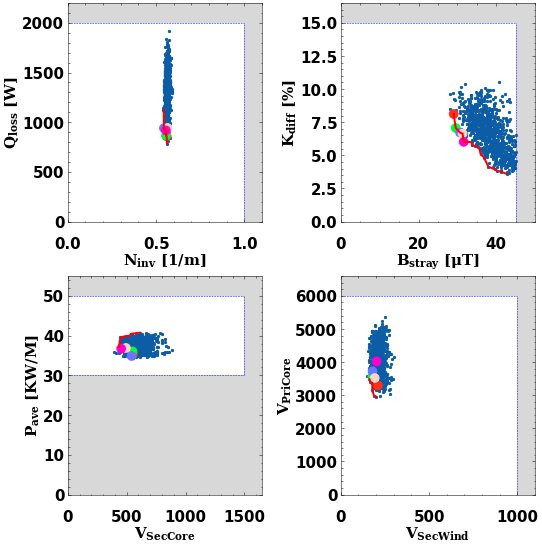

a: 92.2203369140625, lpx: 163.8536376953125, lpy: 1158.8985595703125, ls: 112.15200805664062, p: 95.36271667480469, wp: 173.50033569335938, ws: 60.306373596191406, ip: 95.37366485595703, np: 5.0, ns: 7.0


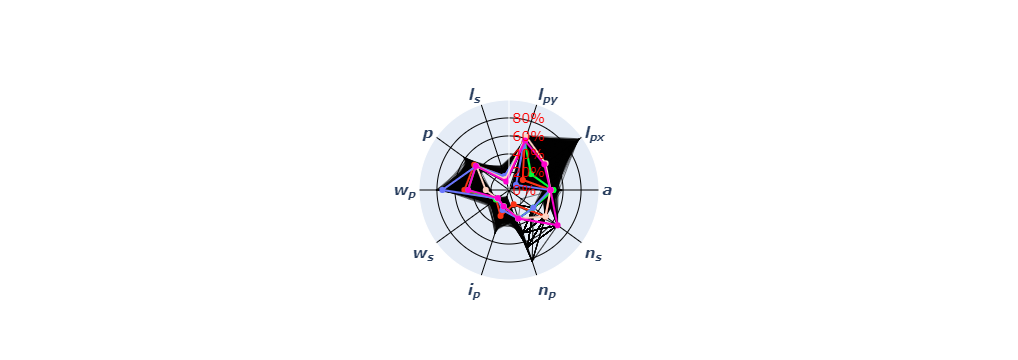

<Figure size 252x189 with 0 Axes>

In [27]:
n_noise = 1000
noise = generate_noise(shape=(n_noise, 10))

gp_model = torch.load(f"gp/gp_model_"+ best_epoch + ".pt")
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

V_PriCore, V_SecCore, V_PriWind,V_SecWind, V_PriCore_ave = core_losses(extra_parameters,gp_parameters)
numinv = number_of_inverters(gp_parameters)

# Scale GP parameters - why?
min_x = torch.min(gp_parameters)
max_x = torch.max(gp_parameters)
gp_parameters = (gp_parameters - min_x) / (max_x - min_x)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

coilloss,pave = calculate_coilloss_pave(k_parameters, l_parameters, b_parameters, extra_parameters)

kwargs = {}

kwargs["kdiff"] = kdiff.clone().detach().cpu().numpy()
kwargs["pave"] = pave.clone().detach().cpu().numpy()
kwargs["coilloss"] = coilloss.clone().detach().cpu().numpy()
kwargs["bstray"] = bstray.clone().detach().cpu().numpy()
kwargs["vpricore"] = V_PriCore_ave.clone().detach().cpu().numpy()
kwargs["vsecwind"] = V_SecWind.clone().detach().cpu().numpy()
kwargs["n_inv"] = numinv.clone().detach().cpu().numpy()
kwargs["vseccore"] = V_SecCore.clone().detach().cpu().numpy()
kwargs["epoch"] = epoch

accepted_ind = passing_index(**kwargs)
acc_ind_tensor = torch.tensor(accepted_ind).cuda()

kdiff = torch.index_select(kdiff.clone(), 0, acc_ind_tensor)
bstray = torch.index_select(bstray.clone(), 0, acc_ind_tensor)
numinv = torch.index_select(numinv.clone(), 0, acc_ind_tensor)
coilloss = torch.index_select(coilloss.clone(), 0, acc_ind_tensor)
pave = torch.index_select(pave.clone(), 0, acc_ind_tensor)
V_SecCore = torch.index_select(V_SecCore.clone(), 0, acc_ind_tensor)
V_SecWind = torch.index_select(V_SecWind.clone(), 0, acc_ind_tensor)
V_PriCore_ave = torch.index_select(V_PriCore_ave.clone(), 0, acc_ind_tensor)

print(bstray.size())

a = (torch.index_select(a, 0, acc_ind_tensor))
lpx = (torch.index_select(lpx, 0, acc_ind_tensor))
lpy = (torch.index_select(lpy, 0, acc_ind_tensor))
ls = (torch.index_select(ls, 0, acc_ind_tensor))
p = (torch.index_select(p, 0, acc_ind_tensor))
wp = (torch.index_select(wp, 0, acc_ind_tensor))
ws = (torch.index_select(ws, 0, acc_ind_tensor))
ip = (torch.index_select(ip, 0, acc_ind_tensor))
np = (torch.index_select(np, 0, acc_ind_tensor))
ns = (torch.index_select(ns, 0, acc_ind_tensor))

print(a.size())
#pmax - pave_kW, to get tensor to minimize, pavemin is tensor to minimize
pavemin = torch.sub(10000, pave)

pareto_n_inv, pareto_coilloss = _pareto_frontier(numinv, coilloss)
pareto_bstray, pareto_kdiff = _pareto_frontier(bstray, kdiff)
pareto_v_seccore, pareto_pavemin = _pareto_frontier(V_SecCore, pavemin)
pareto_v_secwind, pareto_v_pricoreave = _pareto_frontier(V_SecWind, V_PriCore_ave)

#choose which pareto set to use
if p_set == "BstrayKidff":
    pareto_choice = pareto_bstray
    generic_choice = bstray
elif p_set == "NinvQloss":
    pareto_choice = pareto_coilloss
    generic_choice = coilloss
elif p_set == "VseccorePave":
    pareto_choice = pareto_v_seccore
    generic_choice = V_SecCore
elif p_set == "VpricoreVsecwind":
    pareto_choice = pareto_v_secwind
    generic_choice = V_SecWind
else:
    pareto_choice = pareto_bstray
    generic_choice = bstray

T = torch.empty(0).cuda()

for point in range(pareto_choice.size(0)):
    T = torch.cat((T, (generic_choice == pareto_choice[point]).nonzero(as_tuple=True)[0]))
    T = T.type(torch.int64)
pareto_ind = T.clone().detach().cpu().numpy()
    
pareto_pave_post = pave_tomax(pareto_pavemin)

kwargs["kdiff"] = kdiff.clone().detach().cpu().numpy()
kwargs["pave"] = pave.clone().detach().cpu().numpy()
kwargs["coilloss"] = coilloss.clone().detach().cpu().numpy()
kwargs["bstray"] = bstray.clone().detach().cpu().numpy()
kwargs["vpricore"] = V_PriCore_ave.clone().detach().cpu().numpy()
kwargs["vsecwind"] = V_SecWind.clone().detach().cpu().numpy()
kwargs["n_inv"] = numinv.clone().detach().cpu().numpy()
kwargs["vseccore"] = V_SecCore.clone().detach().cpu().numpy()

kwargs["pareto_numinv"] = pareto_n_inv.clone().detach().cpu().numpy()
kwargs["pareto_coilloss"] = pareto_coilloss.clone().detach().cpu().numpy()
kwargs["pareto_bstray"] = pareto_bstray.clone().detach().cpu().numpy()
kwargs["pareto_kdiff"] = pareto_kdiff.clone().detach().cpu().numpy()
kwargs["pareto_v_seccore"] = pareto_v_seccore.clone().detach().cpu().numpy()
kwargs["pareto_pave"] = pareto_pave_post.clone().detach().cpu().numpy()
kwargs["pareto_v_secwind"] = pareto_v_secwind.clone().detach().cpu().numpy()
kwargs["pareto_v_pricore"] = pareto_v_pricoreave.clone().detach().cpu().numpy()


kwargs["p_kdiff"] = (torch.index_select(kdiff, 0, T)).clone().detach().cpu().numpy()
kwargs["p_pave"] = (torch.index_select(pave, 0, T)).clone().detach().cpu().numpy()
kwargs["p_coilloss"] = (torch.index_select(coilloss, 0, T)).clone().detach().cpu().numpy()
kwargs["p_bstray"] = (torch.index_select(bstray, 0, T)).clone().detach().cpu().numpy()
kwargs["p_vpricore"] = (torch.index_select(V_PriCore_ave, 0, T)).clone().detach().cpu().numpy()
kwargs["p_vsecwind"] = (torch.index_select(V_SecWind, 0, T)).clone().detach().cpu().numpy()
kwargs["p_n_inv"] = (torch.index_select(numinv, 0, T)).clone().detach().cpu().numpy()
kwargs["p_vseccore"] = (torch.index_select(V_SecCore, 0, T)).clone().detach().cpu().numpy()

gpargs = {}

gpargs["a"] = a.clone().detach().cpu().numpy()
gpargs["lpx"] = lpx.clone().detach().cpu().numpy()
gpargs["lpy"] = lpy.clone().detach().cpu().numpy()
gpargs["ls"] = ls.clone().detach().cpu().numpy()
gpargs["p"] = p.clone().detach().cpu().numpy()
gpargs["wp"] = wp.clone().detach().cpu().numpy()
gpargs["ws"] = ws.clone().detach().cpu().numpy()
gpargs["ip"] = ip.clone().detach().cpu().numpy()
gpargs["np"] = np.clone().detach().cpu().numpy()
gpargs["ns"] = ns.clone().detach().cpu().numpy()

gpargs["p_a"] = (torch.index_select(a, 0, T)).clone().detach().cpu().numpy()
gpargs["p_lpx"] = (torch.index_select(lpx, 0, T)).clone().detach().cpu().numpy()
gpargs["p_lpy"] = (torch.index_select(lpy, 0, T)).clone().detach().cpu().numpy()
gpargs["p_ls"] = (torch.index_select(ls, 0, T)).clone().detach().cpu().numpy()
gpargs["p_p"] = (torch.index_select(p, 0, T)).clone().detach().cpu().numpy()
gpargs["p_wp"] = (torch.index_select(wp, 0, T)).clone().detach().cpu().numpy()
gpargs["p_ws"] = (torch.index_select(ws, 0, T)).clone().detach().cpu().numpy()
gpargs["p_ip"] = (torch.index_select(ip, 0, T)).clone().detach().cpu().numpy()
gpargs["p_np"] = (torch.index_select(np, 0, T)).clone().detach().cpu().numpy()
gpargs["p_ns"] = (torch.index_select(ns, 0, T)).clone().detach().cpu().numpy()



# print(accepted_ind)
# points_to_plot = 1
if p_set == "BstrayKdiff":
    if len(pareto_bstray) >= points_to_plot: 
        p_points = points_to_plot
    else: p_points = len(pareto_bstray)
elif p_set == "NinvQloss":
    if len(pareto_coilloss) >= points_to_plot: 
        p_points = points_to_plot
    else: p_points = len(pareto_coilloss)
elif p_set == "VseccorePave":
    if len(pareto_v_seccore) >= points_to_plot: 
        p_points = points_to_plot
    else: p_points = len(pareto_v_seccore)
elif p_set == "VpricoreVsecwind":
    if len(pareto_v_pricoreave) >= points_to_plot: 
        p_points = points_to_plot
    else: p_points = len(pareto_v_pricoreave)
else:
    p_points = points_to_plot 

generic_plot_pareto(n_noise, points_to_plot, **kwargs)

spider_diversity_plot_with_pareto(accepted_ind, pareto_ind, points_to_plot, **gpargs)


In [28]:
def scatterplot_matrix(ind, **kwargs):
    plt.close('all')
    
    kdiff = kwargs["kdiff"] * 100
    pave = kwargs["pave"] 
    coilloss = kwargs["coilloss"]
    bstray = kwargs["bstray"]
    vpricore = kwargs["vpricore"]
    vsecwind = kwargs["vsecwind"]
    n_inv = kwargs["n_inv"]
    vseccore = kwargs["vseccore"]
    epoch = kwargs["epoch"]
    
    parameters = [kdiff, pave, coilloss, bstray, vpricore, vsecwind, n_inv, vseccore]
    
    df = pd.DataFrame(data = parameters)
    df = df.transpose()
    df.columns = ["kdiff", "pave", "coilloss", 
                  "bstray", "vpricore","vsecwind",
                  "n_inv", "vseccore"]
    
    df = df.iloc[ind]
    df.reset_index(drop=True, inplace=True)
    
    # categories = ['<i><b>k<sub>diff</sub></b></i>', '<i><b>p<sub>ave</sub></b></i>', '<i><b>Q<sub>loss</sub></b></i>', 
    #               '<i><b>B<sub>stray</sub></b></i>', '<i><b>V<sub>PriCore</sub></b></i>','<i><b>V<sub>SecWind</sub></b></i>',
    #               '<i><b>N<sub>inv</sub></b></i>', '<i><b>V<sub>SecCore</sub></b></i>']
    
    categories = {'kdiff' : '$k_{diff}$', 'pave' : '$P_{ave}$', 'coilloss' : '$Q_{loss}$', 
                  'bstray' : '$B_{stray}$', 'vpricore' : '$V_{PriCore}$', 'vsecwind' : '$V_{SecWind}$',
                  'n_inv' : '$N_{inv}$', 'vseccore' : '$V_{SecCore}$'}
    
    g = sns.pairplot(df, plot_kws={'s': 15})
    g.axes[0,0].set_xlim((0,15))
    g.axes[0,1].set_xlim((30,50))
    g.axes[0,2].set_xlim((0,2000))
    g.axes[0,3].set_xlim((0,45))
    g.axes[0,4].set_xlim((0,6000))
    g.axes[0,5].set_xlim((0,1000))
    g.axes[0,6].set_xlim((0,1))
    g.axes[0,7].set_xlim((0,1500))
    
    g.axes[0,0].set_ylim((0,15))
    g.axes[1,0].set_ylim((30,50))
    g.axes[2,0].set_ylim((0,2000))
    g.axes[3,0].set_ylim((0,45))
    g.axes[4,0].set_ylim((0,6000))
    g.axes[5,0].set_ylim((0,1000))
    g.axes[6,0].set_ylim((0,1))
    g.axes[7,0].set_ylim((0,1500))
    
    for i in range(8):
        for j in range(8):
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
            if xlabel in categories.keys():
                g.axes[i][j].set_xlabel(categories[xlabel])
            if ylabel in categories.keys():
                g.axes[i][j].set_ylabel(categories[ylabel])
    if save_figs == True:
        g.savefig(f'objectives_scattermatrix_{loss_function}.png')
        # g.savefig(f'{folder_name}/objectives_scattermatrix.png')

In [29]:
n_noise = 1000
noise = generate_noise(shape=(n_noise, 10))

gp_model = torch.load(f"gp/gp_model_"+ best_epoch + ".pt")
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

V_PriCore, V_SecCore, V_PriWind,V_SecWind, V_PriCore_ave = core_losses(extra_parameters,gp_parameters)
numinv = number_of_inverters(gp_parameters)

# Scale GP parameters - why?
min_x = torch.min(gp_parameters)
max_x = torch.max(gp_parameters)
gp_parameters = (gp_parameters - min_x) / (max_x - min_x)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
coilloss,pave = calculate_coilloss_pave(k_parameters, l_parameters, b_parameters, extra_parameters)

#pmax - pave_kW, to get tensor to minimize, pavemin is tensor to minimize
pavemin = torch.sub(10000, pave)

kwargs = {}

kwargs["kdiff"] = kdiff.clone().detach().cpu().numpy()
kwargs["pave"] = pave.clone().detach().cpu().numpy()
kwargs["coilloss"] = coilloss.clone().detach().cpu().numpy()
kwargs["bstray"] = bstray.clone().detach().cpu().numpy()
kwargs["vpricore"] = V_PriCore_ave.clone().detach().cpu().numpy()
kwargs["vsecwind"] = V_SecWind.clone().detach().cpu().numpy()
kwargs["n_inv"] = numinv.clone().detach().cpu().numpy()
kwargs["vseccore"] = V_SecCore.clone().detach().cpu().numpy()
kwargs["epoch"] = epoch

accepted_ind = passing_index(**kwargs)

scatterplot_matrix(accepted_ind, **kwargs)

## Coil Diagram
example coil diagram \
"not automated"

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


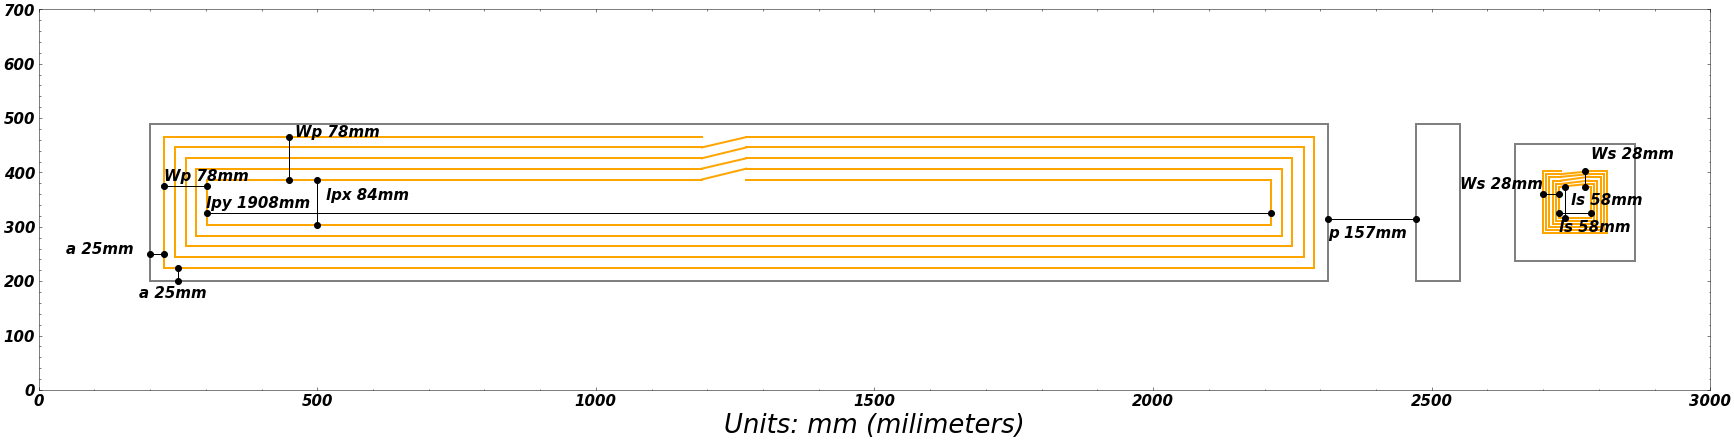

In [30]:

plt.rcParams["figure.figsize"] = (29.96, 7)
plt.rcParams['font.style'] = 'italic'
plt.axis([0,3000, 0,700])

plt.plot((200, 200), (200, 490), c='grey', lw=2)
plt.plot((200, 2314), (200, 200), c='grey', lw=2)
plt.plot((200, 2314), (490, 490), c='grey', lw=2)
plt.plot((2314, 2314), (200, 490), c='grey', lw=2)

plt.plot((2471, 2471), (200, 490), c='grey', lw=2)
plt.plot((2471, 2550), (200, 200), c='grey', lw=2)
plt.plot((2471, 2550), (490, 490), c='grey', lw=2)
plt.plot((2550, 2550), (200, 490), c='grey', lw=2)

plt.plot((225, 1190), (465, 465), c='orange', lw=2)
plt.plot((1270, 2289), (465, 465), c='orange', lw=2)
plt.plot((225, 225), (225, 465), c='orange', lw=2)
plt.plot((225, 2289), (225, 225), c='orange', lw=2)
plt.plot((2289, 2289), (225, 465), c='orange', lw=2)

plt.plot((303, 1190), (387, 387), c='orange', lw=2)
plt.plot((1270, 2211), (387, 387), c='orange', lw=2)
plt.plot((303, 303), (303, 387), c='orange', lw=2)
plt.plot((303, 2211), (303, 303), c='orange', lw=2)
plt.plot((2211, 2211), (303, 387), c='orange', lw=2)

plt.plot((244, 1190), (446, 446), c='orange', lw=2)
plt.plot((1270, 2270), (446, 446), c='orange', lw=2)
plt.plot((244, 244), (244, 446), c='orange', lw=2)
plt.plot((244, 2270), (244, 244), c='orange', lw=2)
plt.plot((2270, 2270), (244, 446), c='orange', lw=2)

plt.plot((264, 1190), (426, 426), c='orange', lw=2)
plt.plot((1270, 2250), (426, 426), c='orange', lw=2)
plt.plot((264, 264), (264, 426), c='orange', lw=2)
plt.plot((264, 2250), (264, 264), c='orange', lw=2)
plt.plot((2250, 2250), (264, 426), c='orange', lw=2)

plt.plot((283, 1190), (407, 407), c='orange', lw=2)
plt.plot((1270, 2231), (407, 407), c='orange', lw=2)
plt.plot((283, 283), (283, 407), c='orange', lw=2)
plt.plot((283, 2231), (283, 283), c='orange', lw=2)
plt.plot((2231, 2231), (283, 407), c='orange', lw=2)

plt.plot((1190, 1270), (387, 407), c='orange', lw=2)
plt.plot((1190, 1270), (407, 426), c='orange', lw=2)
plt.plot((1190, 1270), (426, 446), c='orange', lw=2)
plt.plot((1190, 1270), (446, 465), c='orange', lw=2)
# plt.plot((1002, 1082), (989, 1028), c='orange', lw=2)
# plt.plot((1002, 1082), (1028, 1067), c='orange', lw=2)

plt.plot((2700, 2732), (402, 402), c='orange', lw=2)
plt.plot((2782, 2814), (402, 402), c='orange', lw=2)
plt.plot((2700, 2700), (288, 402), c='orange', lw=2)
plt.plot((2700, 2814), (288, 288), c='orange', lw=2)
plt.plot((2814, 2814), (288, 402), c='orange', lw=2)

plt.plot((2728, 2732), (374, 374), c='orange', lw=2)
plt.plot((2782, 2786), (374, 374), c='orange', lw=2)
plt.plot((2728, 2728), (316, 374), c='orange', lw=2)
plt.plot((2728, 2786), (316, 316), c='orange', lw=2)
plt.plot((2786, 2786), (316, 374), c='orange', lw=2)


plt.plot((2705, 2732), (397, 397), c='orange', lw=2)
plt.plot((2782, 2809), (397, 397), c='orange', lw=2)
plt.plot((2705, 2705), (294, 397), c='orange', lw=2)
plt.plot((2705, 2809), (294, 294), c='orange', lw=2)
plt.plot((2809, 2809), (294, 397), c='orange', lw=2)

plt.plot((2710, 2732), (392, 392), c='orange', lw=2)
plt.plot((2782, 2804), (392, 392), c='orange', lw=2)
plt.plot((2710, 2710), (299, 392), c='orange', lw=2)
plt.plot((2710, 2804), (299, 299), c='orange', lw=2)
plt.plot((2804, 2804), (299, 392), c='orange', lw=2)

plt.plot((2717, 2732), (385, 385), c='orange', lw=2)
plt.plot((2782, 2797), (385, 385), c='orange', lw=2)
plt.plot((2717, 2717), (305, 385), c='orange', lw=2)
plt.plot((2717, 2797), (305, 305), c='orange', lw=2)
plt.plot((2797, 2797), (305, 385), c='orange', lw=2)

plt.plot((2723, 2732), (379, 379), c='orange', lw=2)
plt.plot((2782, 2791), (379, 379), c='orange', lw=2)
plt.plot((2723, 2723), (311, 379), c='orange', lw=2)
plt.plot((2723, 2791), (311, 311), c='orange', lw=2)
plt.plot((2791, 2791), (311, 379), c='orange', lw=2)

plt.plot((2732, 2782), (374, 379), c='orange', lw=2)
plt.plot((2732, 2782), (379, 385), c='orange', lw=2)
plt.plot((2732, 2782), (385, 392), c='orange', lw=2)
plt.plot((2732, 2782), (392, 397), c='orange', lw=2)
plt.plot((2732, 2782), (397, 402), c='orange', lw=2)

plt.plot((2650, 2650), (238, 452), c='grey', lw=2)
plt.plot((2650, 2864), (238, 238), c='grey', lw=2)
plt.plot((2650, 2864), (452, 452), c='grey', lw=2)
plt.plot((2864, 2864), (238, 452), c='grey', lw=2)

plt.rcParams['font.style'] = 'italic'
plt.plot((200, 225), (250, 250), c='black', marker='o')
plt.annotate('a 25mm', (50, 250))

plt.plot((250, 250), (200, 225), c='black', marker='o')
plt.annotate('a 25mm', (180, 170))

plt.plot((500, 500), (303, 387), c='black', marker='o')
plt.annotate('lpx 84mm', (515, 350))

plt.plot((303, 2211), (325, 325), c='black', marker='o')
plt.annotate('lpy 1908mm', (300, 335))

plt.plot((450, 450), (387, 465), c='black', marker='o')
plt.annotate('Wp 78mm', (460, 465))

plt.plot((225, 303), (375, 375), c='black', marker='o')
plt.annotate('Wp 78mm', (225, 385))

plt.plot((2314, 2471), (315, 315), c='black', marker='o')
plt.annotate('p 157mm', (2314, 280))


plt.plot((2728, 2786), (325, 325), c='black', marker='o')
plt.annotate('ls 58mm', (2728, 290))

plt.plot((2700, 2728), (360, 360), c='black', marker='o')
plt.annotate('Ws 28mm', (2550, 370))

plt.plot((2740, 2740), (316, 374), c='black', marker='o')
plt.annotate('ls 58mm', (2750, 340), style='italic')

plt.plot((2775, 2775), (374, 402), c='black', marker='o')
plt.annotate('Ws 28mm', (2786, 425), style='italic')

plt.xlabel('Units: mm (milimeters)', size='xx-large')
if save_figs == True:
    plt.savefig(f"coil_diagram_{loss_function}.png")
plt.show()